<a href="https://colab.research.google.com/github/armiro/Pneumothorax-Segmentation/blob/master/dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydicom

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil, glob, cv2, pydicom
import pandas as pd

In [3]:
# first, load the dataset
path = '/content/drive/My Drive/Datasets/siim_acr_pneumothorax_seg/siim_acr_step1/siim'
training_path = path + '/dicom-images-train/*/*/*.dcm'
test_path = path + '/dicom-images-test/_/_/*.dcm'

X_train = glob.glob(pathname=training_path)
X_test = glob.glob(pathname=test_path)

metadata = pd.read_csv(filepath_or_buffer=path+'/train-rle.csv', index_col='ImageId')
print('metadata header:', metadata.columns)

metadata header: Index([' EncodedPixels'], dtype='object')


storage info:
study ID: 1.2.276.0.7230010.3.1.2.8323329.12555.1517875239.694137
series ID: 1.2.276.0.7230010.3.1.3.8323329.12555.1517875239.694136
image ID: 1.2.276.0.7230010.3.1.4.8323329.12555.1517875239.694138
storage type: 1.2.840.10008.5.1.4.1.1.7

patient info:
ID: f935f85a-7656-4303-bfe8-c0c41331a3b4 / sex: M / age: 31

x-ray info:
modality: CR / body-part: CHEST / view: AP

image info:
image size: 1024 * 1024
image pixel spacing: [0.171, 0.171]



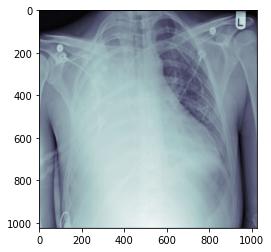

In [9]:
# print dicom metadata and plot image pixels for a random image
def show_dcm_info(image):
    print('storage info:')
    print('study ID:', image.StudyInstanceUID)
    print('series ID:', image.SeriesInstanceUID)
    print('image ID:', image.SOPInstanceUID)
    print('storage type:', image.SOPClassUID)
    print()
    print('patient info:')
    print('ID:', image.PatientID, '/ sex:', image.PatientSex, '/ age:', image.PatientAge)
    print()
    print('x-ray info:')
    print('modality:', image.Modality, '/ body-part:', image.BodyPartExamined,
          '/ view:', image.ViewPosition)
    print()
    print('image info:')
    if 'PixelData' in image:
        rows = int(image.Rows)
        columns = int(image.Columns)
        print('image size: %d * %d' %(rows, columns))
    if 'PixelSpacing' in image:
        print('image pixel spacing:', image.PixelSpacing)
    print()
    

def plot_dcm_image(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(X=image.pixel_array, cmap='bone')
    plt.show()



test_img = pydicom.dcmread(X_train[np.random.randint(0, len(X_train))])
show_dcm_info(image=test_img)
plot_dcm_image(image=test_img)


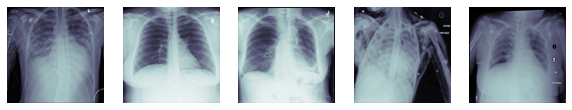

In [10]:
# let's see some snaps from the dataset
num_snaps = 5
indices = np.random.randint(low=0, high=len(X_train), size=num_snaps)

fig = plt.figure(figsize=(10, 50))
for i in range(1, num_snaps+1):
    plt.subplot(1, num_snaps, i)
    this_img = pydicom.read_file(fp=X_train[indices[i-1]])
    plt.imshow(X=this_img.pixel_array, cmap='bone')
    plt.axis('off')
plt.show()
fig.savefig(fname='dataset_snaps.png', bbox_inches='tight')

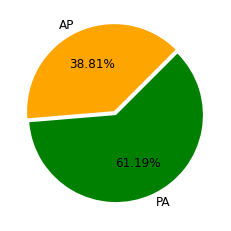

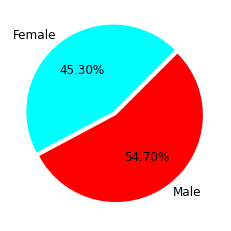

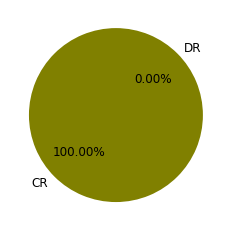

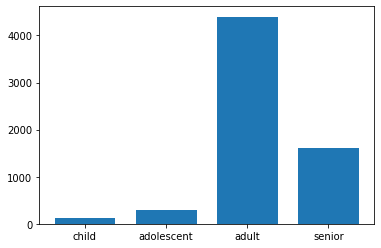

In [11]:
# plot the distribution of each metadata feature in the dataset
projections = [0, 0]
patient_sex = [0, 0]
modality = [0, 0]
patient_age = [0, 0, 0, 0]
for img_path in X_test+X_test:
    this_img = pydicom.read_file(fp=img_path, stop_before_pixels=True)
    # projection
    if this_img.ViewPosition == 'AP':
        projections[0] += 1
    elif this_img.ViewPosition == 'PA':
        projections[1] += 1
    else:
        print('unknown projection')
    # patient sex
    if this_img.PatientSex == 'F':
        patient_sex[0] += 1
    elif this_img.PatientSex == 'M':
        patient_sex[1] += 1
    else:
        print('unknown patient sex')
    # modality
    if this_img.Modality == 'CR':
        modality[0] += 1
    elif this_img.Modality == 'DR':
        modality[1] += 1
    else:
        print('unknown modality')
    # patient age (boundaries: https://www.cdc.gov/nchs/products/databriefs/db334.htm)
    if int(this_img.PatientAge) <= 11:
        patient_age[0] += 1
    elif 12 <= int(this_img.PatientAge) <= 19:
        patient_age[1] += 1
    elif 20 <= int(this_img.PatientAge) <= 59:
        patient_age[2] += 1
    elif 60 <= int(this_img.PatientAge):
        patient_age[3] += 1
    else:
        print('unknown patient age')
    
    # if int(this_img.Rows) != 1024:
    #     print(this_img.Rows, this_img.Columns) 


fig = plt.figure()
plt.pie(x=projections, explode=(0.05, 0.0), labels=['AP', 'PA'], colors=['orange', 'green'],
        autopct='%1.2f%%', startangle=45, textprops={'fontsize': 12.0})
plt.show()
fig.savefig(fname='projections.png', bbox_inches='tight')

fig = plt.figure()
plt.pie(x=patient_sex, explode=(0.05, 0.0), labels=['Female', 'Male'], colors=['cyan', 'red'],
        autopct='%1.2f%%', startangle=45, textprops={'fontsize': 12.0})
plt.show()
fig.savefig(fname='patient_sex.png', bbox_inches='tight')

fig = plt.figure()
plt.pie(x=modality, labels=['CR', 'DR'], colors=['olive', 'purple'],
        autopct='%1.2f%%', startangle=45, textprops={'fontsize': 12.0})
plt.show()
fig.savefig(fname='modality.png', bbox_inches='tight')

fig = plt.figure()
plt.bar(x=['child', 'adolescent', 'adult', 'senior'], height=patient_age, width=0.75)
plt.show()
fig.savefig(fname='patient_age.png', bbox_inches='tight')

In [14]:
len(X_test+X_train)

15294